In [1]:
import sys, os, time, datetime, csv
sys.path.insert(1, '/Users/lucascurtin/Desktop/QGNN Repos/qtrkx-gnn-tracking/tools')
from tools import *
import numpy as np
import math
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from mpl_toolkits.mplot3d import Axes3D

from tqdm import tqdm
from matplotlib.lines import Line2D

import pandas as pd

In [2]:
def plot_cartesian(filenames,n_section,n_files):
        fig, ax = plt.subplots(1,2,figsize = (10,5),sharey=True, tight_layout=True)
        cmap = plt.get_cmap('bwr_r')
        theta_counter = 0 # start 45 degree rotated
        total_false_edges = 0
        total_true_edges = 0
        for i in range(n_files):
            print('Plotting file: ' + filenames[i])
            X, Ri, Ro, y = load_graph(filenames[i])
            #print('Zmin: %.2f, Zmax: %.2f' %(min(X[:,2]),max(X[:,2]))   )
            X[:,1] = X[:,1] * np.pi/n_section
            theta = (X[:,1] + theta_counter)%(np.pi*2)
           
            ax[0].scatter(1000*X[:,0]*np.cos(theta), 1000*X[:,0]*np.sin(theta), c='k', s=3)
            ax[1].scatter(1000*X[:,0]*np.cos(theta), 1000*X[:,0]*np.sin(theta), c='k', s=3)

            #ax1.scatter(1000*X[:,0]*np.cos(theta), 1000*X[:,2], c='k')

            feats_o = X[np.where(Ri.T)[1]]
            feats_i = X[np.where(Ro.T)[1]]

            x_o = 1000*feats_o[:,0]*np.cos(feats_o[:,1]+theta_counter)
            x_i = 1000*feats_i[:,0]*np.cos(feats_i[:,1]+theta_counter)
            y_o = 1000*feats_o[:,0]*np.sin(feats_o[:,1]+theta_counter)
            y_i = 1000*feats_i[:,0]*np.sin(feats_i[:,1]+theta_counter)

            # print only false edges
            for j in range(y.shape[0]):
                seg_args = dict(c='darkblue', alpha=1-y[j])
                ax[0].plot([x_o[j],x_i[j]],[y_o[j],y_i[j]], '-', **seg_args)

            
            # print only true edges
            for j in range(y.shape[0]):
                seg_args = dict(c='darkblue', alpha=y[j])
                ax[1].plot([x_o[j],x_i[j]],[y_o[j],y_i[j]], '-', **seg_args)

            # draw seperator line
            ax[0].plot([0,1100*np.cos(theta_counter-np.pi/n_section)],[0,1100*np.sin(theta_counter-np.pi/n_section)],'-', c='darkorange')
            ax[0].plot([0,1100*np.cos(theta_counter+np.pi/n_section)],[0,1100*np.sin(theta_counter+np.pi/n_section)],'-', c='darkorange')
            ax[1].plot([0,1100*np.cos(theta_counter-np.pi/n_section)],[0,1100*np.sin(theta_counter-np.pi/n_section)],'-', c='darkorange')
            ax[1].plot([0,1100*np.cos(theta_counter+np.pi/n_section)],[0,1100*np.sin(theta_counter+np.pi/n_section)],'-', c='darkorange')

            total_true_edges  += sum(y)
            total_false_edges += y.shape[0] - sum(y)

            theta_counter += 2*np.pi/n_section
            theta_counter = theta_counter%(np.pi*2)

        print('Plotting a graph with %d true, %d false, %d total edges'%(total_true_edges,total_false_edges,total_false_edges+total_true_edges))

        ax[0].set_xlabel('x [mm]')
        ax[0].set_ylabel('y [mm]')
        ax[1].set_xlabel('$x [mm]$')
        ax[1].set_ylabel('$y [mm]$')
        ax[0].set_aspect('equal')
        ax[1].set_aspect('equal')
        ax[0].set_title('Only Fake Edges (After Preprocessing)')
        ax[1].set_title('Only True Edges (After Preprocessing)')
       
        plt.show()

In [3]:
def plot_cartesian_single(filenames,n_section,n_files):
        fig, ax = plt.subplots(1,2,figsize = (10,5),sharey=True, tight_layout=True)
        cmap = plt.get_cmap('bwr_r')
        theta_counter = 0 # start 45 degree rotated
        total_false_edges = 0
        total_true_edges = 0
        
        print('Plotting file: ' + filenames)
        X, Ri, Ro, y = load_graph(filenames)
        #print('Zmin: %.2f, Zmax: %.2f' %(min(X[:,2]),max(X[:,2]))   )
        X[:,1] = X[:,1] * np.pi/n_section
        theta = (X[:,1] + theta_counter)%(np.pi*2)
        
        ax[0].scatter(1000*X[:,0]*np.cos(theta), 1000*X[:,0]*np.sin(theta), c='k', s=3)
        ax[1].scatter(1000*X[:,0]*np.cos(theta), 1000*X[:,0]*np.sin(theta), c='k', s=3)

        #ax1.scatter(1000*X[:,0]*np.cos(theta), 1000*X[:,2], c='k')

        feats_o = X[np.where(Ri.T)[1]]
        feats_i = X[np.where(Ro.T)[1]]

        x_o = 1000*feats_o[:,0]*np.cos(feats_o[:,1]+theta_counter)
        x_i = 1000*feats_i[:,0]*np.cos(feats_i[:,1]+theta_counter)
        y_o = 1000*feats_o[:,0]*np.sin(feats_o[:,1]+theta_counter)
        y_i = 1000*feats_i[:,0]*np.sin(feats_i[:,1]+theta_counter)

        # print only false edges
        for j in range(y.shape[0]):
            seg_args = dict(c='darkblue', alpha=1-y[j])
            ax[0].plot([x_o[j],x_i[j]],[y_o[j],y_i[j]], '-', **seg_args)
        # print only true edges
        for j in range(y.shape[0]):
            seg_args = dict(c='darkblue', alpha=y[j])
            ax[1].plot([x_o[j],x_i[j]],[y_o[j],y_i[j]], '-', **seg_args)

        # draw seperator line
        ax[0].plot([0,1100*np.cos(theta_counter-np.pi/n_section)],[0,1100*np.sin(theta_counter-np.pi/n_section)],'-', c='darkorange')
        ax[0].plot([0,1100*np.cos(theta_counter+np.pi/n_section)],[0,1100*np.sin(theta_counter+np.pi/n_section)],'-', c='darkorange')
        ax[1].plot([0,1100*np.cos(theta_counter-np.pi/n_section)],[0,1100*np.sin(theta_counter-np.pi/n_section)],'-', c='darkorange')
        ax[1].plot([0,1100*np.cos(theta_counter+np.pi/n_section)],[0,1100*np.sin(theta_counter+np.pi/n_section)],'-', c='darkorange')

        total_true_edges  += sum(y)
        total_false_edges += y.shape[0] - sum(y)

        theta_counter += 2*np.pi/n_section
        theta_counter = theta_counter%(np.pi*2)

        print('Plotting a graph with %d true, %d false, %d total edges'%(total_true_edges,total_false_edges,total_false_edges+total_true_edges))

        ax[0].set_xlabel('x [mm]')
        ax[0].set_ylabel('y [mm]')
        ax[1].set_xlabel('$x [mm]$')
        ax[1].set_ylabel('$y [mm]$')
        ax[0].set_aspect('equal')
        ax[1].set_aspect('equal')
        ax[0].set_title('Only Fake Edges (After Preprocessing)')
        ax[1].set_title('Only True Edges (After Preprocessing)')
       
        plt.show()

In [4]:
cols = [ 'edge', 'label', 'eta', 'phi', 'true_pt', 'layer', 'track_length', 'hit1_id', 'hit2_id', 'particle_num'] #suggested column names
event = pd.DataFrame(np.load('/Users/lucascurtin/Desktop/event_1000/edges_preprocessed_000001000 (1).npy',allow_pickle = True), columns = cols)

In [5]:
true_events=event.loc[event['label'] == 1]

fake_events=event.loc[event['label'] == 0]


Despite me not being to exactly execute Marcin's code, I've found that his number of edges aligns with Tuysuz's one nearly perfectly (off by 3 which could be explained by edge cases possibly?) This means the error lies with how I'm splitting up the code most likely. 

## Plot Reconstruction

So we want to do is to get the edge, get the x y coordinates of each input and output node, plot them with a line between them

In [6]:
x_input=[]
y_input=[]

x_output=[]
y_output=[]

for i in range(len(fake_events)):
    r_i,theta_i,z_i=fake_events['edge'].iloc[i][0:3]
    r_o,theta_o,z_o=fake_events['edge'].iloc[i][3:6]

    x_i=r_i*np.cos(theta_i)
    y_i=r_i*np.sin(theta_i)
    x_input.append(x_i)
    y_input.append(y_i)


    x_o=r_o*np.cos(theta_o)
    y_o=r_o*np.sin(theta_o)
    x_output.append(x_o)
    y_output.append(y_o)



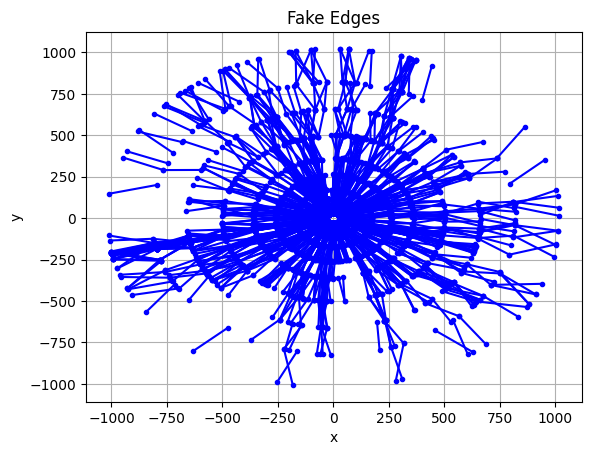

In [7]:
#plt.scatter(x_input, y_input,label='input')
#plt.scatter(x_output,y_output, label='output')
plt.grid()


for i in range(len(x_input)):
    plt.plot([x_input[i],x_output[i]],[y_input[i],y_output[i]],'b.-')


plt.title('Fake Edges')
plt.ylabel("y")
plt.xlabel("x")

plt.show()

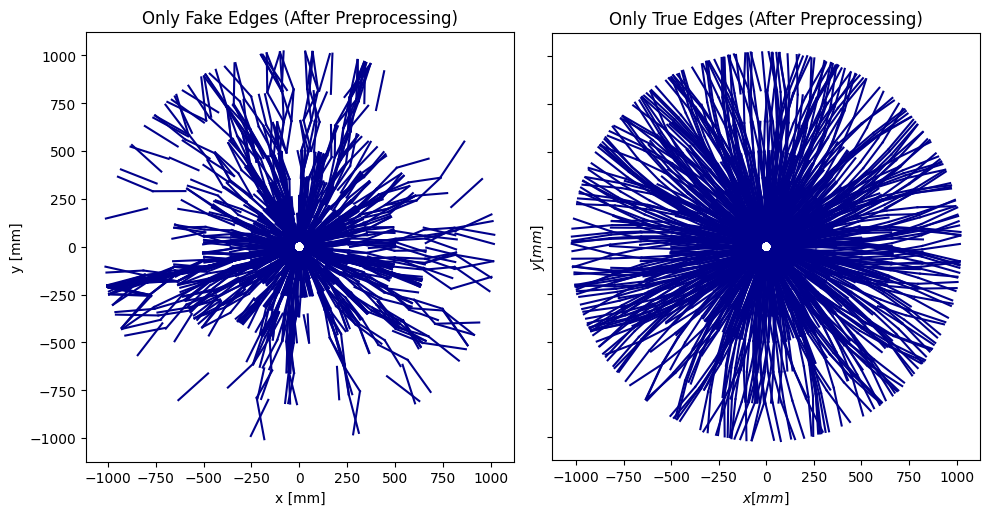

In [10]:
fig, ax = plt.subplots(1,2,figsize = (10,5),sharey=True, tight_layout=True)
cmap = plt.get_cmap('bwr_r')
theta_counter = 0 # start 45 degree rotated
total_false_edges = 0
total_true_edges = 0



x_input=[]
y_input=[]

x_output=[]
y_output=[]


#fake events

for i in range(len(fake_events)):
    r_i,theta_i,z_i=fake_events['edge'].iloc[i][0:3]
    r_o,theta_o,z_o=fake_events['edge'].iloc[i][3:6]

    x_i=r_i*np.cos(theta_i)
    y_i=r_i*np.sin(theta_i)
    x_input.append(x_i)
    y_input.append(y_i)


    x_o=r_o*np.cos(theta_o)
    y_o=r_o*np.sin(theta_o)
    x_output.append(x_o)
    y_output.append(y_o)


#I've update the seg argument lines, not it was erroneusly removing some edges (I think they use it so for each graph they plot the edges and if it has the wrong
#y label for the plot at hand then you can't see it!)

# print only false edges
for j in range(len(fake_events)):
    #seg_args = dict(c='darkblue', alpha=1-y[j])
    seg_args = dict(c='darkblue')
    ax[0].plot([x_output[j],x_input[j]],[y_output[j],y_input[j]], '-', **seg_args)




#true events
x_input=[]
y_input=[]

x_output=[]
y_output=[]

for i in range(len(true_events)):
    r_i,theta_i,z_i=true_events['edge'].iloc[i][0:3]
    r_o,theta_o,z_o=true_events['edge'].iloc[i][3:6]

    x_i=r_i*np.cos(theta_i)
    y_i=r_i*np.sin(theta_i)
    x_input.append(x_i)
    y_input.append(y_i)


    x_o=r_o*np.cos(theta_o)
    y_o=r_o*np.sin(theta_o)
    x_output.append(x_o)
    y_output.append(y_o)



# print only true edges
for j in range(len(true_events)):
    #seg_args = dict(c='darkblue', alpha=y[j])
    seg_args = dict(c='darkblue')
    ax[1].plot([x_output[j],x_input[j]],[y_output[j],y_input[j]], '-', **seg_args)

ax[0].set_xlabel('x [mm]')
ax[0].set_ylabel('y [mm]')
ax[1].set_xlabel('$x [mm]$')
ax[1].set_ylabel('$y [mm]$')
ax[0].set_aspect('equal')
ax[1].set_aspect('equal')
ax[0].set_title('Only Fake Edges (After Preprocessing)')
ax[1].set_title('Only True Edges (After Preprocessing)')

plt.show()

In [ ]:
print('Number of Fake events',len(fake_events))
print('Number of True events',len(true_events))

Number of Fake events 5511
Number of True events 5162


My data:
Plotting file: /Users/lucascurtin/Desktop/QGNN Repos/qtrkx-gnn-tracking/data_personal/tuysuz_original/train/event000001000_g000.npz
Plotting a graph with 5162 true, 5508 false, 10670 total edges


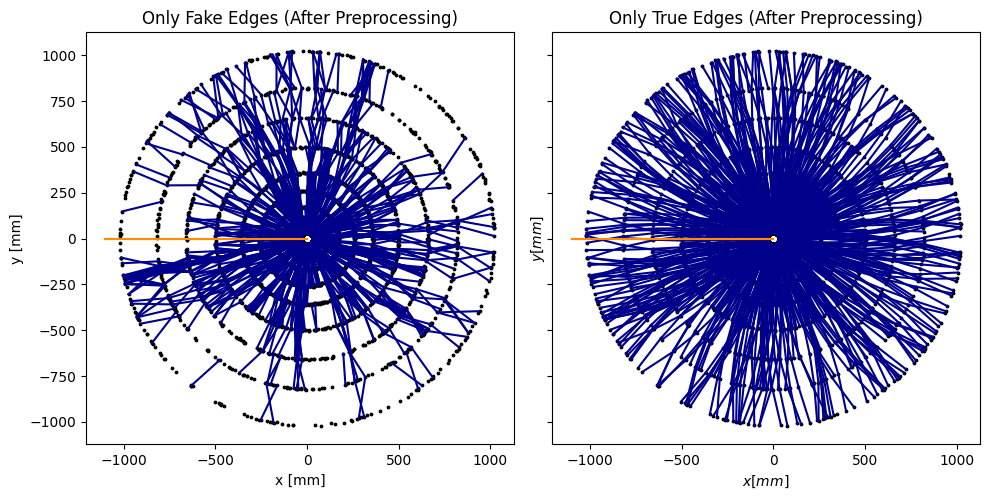

In [ ]:
input_dir=r'/Users/lucascurtin/Desktop/QGNN Repos/qtrkx-gnn-tracking/data_personal/tuysuz_original/train'
n_section = 1
n_files = 1

    
   
input_dir = os.path.expandvars(input_dir)
filenames = sorted([os.path.join(input_dir, f) for f in os.listdir(input_dir) 
            if f.startswith('event') and f.endswith('.npz')])
filenames[:n_files] if n_files is not None else filenames


print('My data:')
plot_cartesian(filenames,n_section,n_files)



# Going to see if we can get the original Tuysuz Data into a Pandas DF

In [ ]:
graph=np.load('/Users/lucascurtin/Desktop/QGNN Repos/qtrkx-gnn-tracking/data_personal/tuysuz_original/train/event000001000_g000.npz')

In [ ]:
X, Ri, Ro, y = load_graph('/Users/lucascurtin/Desktop/QGNN Repos/qtrkx-gnn-tracking/data_personal/tuysuz_original/train/event000001000_g000.npz')

In [ ]:
X, Ri, Ro, y = load_graph('/Users/lucascurtin/Desktop/QGNN Repos/qtrkx-gnn-tracking/data_personal/tuysuz_original/train/event000001000_g000.npz')
#print('Zmin: %.2f, Zmax: %.2f' %(min(X[:,2]),max(X[:,2]))   )
X[:,1] = X[:,1] * np.pi/n_section
theta = (X[:,1] + theta_counter)%(np.pi*2)

ax[0].scatter(1000*X[:,0]*np.cos(theta), 1000*X[:,0]*np.sin(theta), c='k', s=3)
ax[1].scatter(1000*X[:,0]*np.cos(theta), 1000*X[:,0]*np.sin(theta), c='k', s=3)

#ax1.scatter(1000*X[:,0]*np.cos(theta), 1000*X[:,2], c='k')

feats_o = X[np.where(Ri.T)[1]]
feats_i = X[np.where(Ro.T)[1]]

x_o = 1000*feats_o[:,0]*np.cos(feats_o[:,1]+theta_counter)
x_i = 1000*feats_i[:,0]*np.cos(feats_i[:,1]+theta_counter)
y_o = 1000*feats_o[:,0]*np.sin(feats_o[:,1]+theta_counter)
y_i = 1000*feats_i[:,0]*np.sin(feats_i[:,1]+theta_counter)


array([0.03144621, 0.8504313 , 0.0595952 ], dtype=float32)

In [ ]:
X[:,1] #This grabs the second element of each spatial coordinate, which I guess is theta? But then they multiply it by pi

array([0.8504313 , 0.84666234, 0.8430469 , ..., 0.7734815 , 0.787495  ,
       0.80558014], dtype=float32)